## Initialization

In [ ]:
#@title
! git clone https://github.com/proroklab/VectorizedMultiAgentSimulator.git

# github.com:22 SSH-2.0-babeld-7f91b4d6
Cloning into 'VectorizedMultiAgentSimulator'...
remote: Enumerating objects: 1863, done.
remote: Counting objects: 100% (273/273), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 1863 (delta 171), reused 152 (delta 126), pack-reused 1590
Receiving objects: 100% (1863/1863), 89.78 MiB | 16.63 MiB/s, done.
Resolving deltas: 100% (1263/1263), done.


In [ ]:
#@title
%cd /content/VectorizedMultiAgentSimulator
# ! git checkout dev
!pip install -r requirements.txt
!pip install gym==0.22
!apt-get install -y x11-utils 
!apt-get install -y xvfb
!apt-get install -y imagemagick
!pip install -e .

/content/VectorizedMultiAgentSimulator
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54.5 MB 165 kB/s 
     |████████████████████████████████| 1.8 MB 55.4 MB/s 
     |████████████████████████████████| 10.1 MB 49.5 MB/s 
     |████████████████████████████████| 4.1 MB 46.8 MB/s 
     |████████████████████████████████| 144 kB 61.5 MB/s 
     |████████████████████████████████| 1.2 MB 65.3 MB/s 
     |████████████████████████████████| 125 kB 78.0 MB/s 
     |████████████████████████████████| 145 kB 72.7 MB/s 
     |████████████████████████████████| 181 kB 67.2 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 461 kB 69.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=732755cb06d4d643a10b23504e2a736f44f77400aa20fcb7326962535bc0441d
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfe

In [ ]:
#@title
!pip install pyvirtualdisplay
import pyvirtualdisplay
display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
display.start()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Run


In [ ]:
#  Copyright (c) 2022.
#  ProrokLab (https://www.proroklab.org/)
#  All rights reserved.

import time
import numpy as np
import torch
from PIL import Image

from vmas import make_env, Wrapper

scenario_name = "waterfall"

# Scenario specific variables
n_agents = 4

num_envs = 32
continuous_actions = False
device = "cpu"  # or cuda or any other torch device
wrapper = Wrapper.RLLIB # or None
n_steps = 500

simple_2d_action = (
    [0, 0.5] if continuous_actions else [3]
)  # Sample action tell each agent to go down

env = make_env(
    scenario_name=scenario_name,
    num_envs=num_envs,
    device=device,
    continuous_actions=continuous_actions,
    wrapper=wrapper,
    # Environment specific variables
    n_agents=n_agents,
)


frame_list = []  # For creating a gif
init_time = time.time()
for s in range(n_steps):
    actions = []
    if wrapper is Wrapper.RLLIB:  # Rllib interface
        for i in range(num_envs):
            actions_per_env = []
            for j in range(n_agents):
                actions_per_env.append(np.array(simple_2d_action))
            actions.append(actions_per_env)
        obs, rews, dones, info = env.vector_step(actions)
        frame_list.append(
            Image.fromarray(
                env.try_render_at(
                    mode="rgb_array", agent_index_focus=None # Can give the camera an agent index to focus on
                )
            )
        )  

    elif wrapper is None:  # Same as before, with faster VMAS interface
        for i in range(n_agents):
            actions.append(
                torch.tensor(
                    simple_2d_action,
                    device=device,
                ).repeat(num_envs, 1)
            )
        obs, rews, dones, info = env.step(actions)
        frame_list.append(
            Image.fromarray(env.render(mode="rgb_array", agent_index_focus=None))
        )  # Can give the camera an agent index to focus on

gif_name = scenario_name + ".gif"

# Produce a gif
frame_list[0].save(
    gif_name,
    save_all=True,
    append_images=frame_list[1:],
    duration=3,
    loop=0,
)

total_time = time.time() - init_time
print(
        f"It took: {total_time}s for {n_steps} steps of {num_envs} parallel environments on device {device}"
        f" for {wrapper.name}{' wrapped' if wrapper is not None else ''} simulator"
    )

It took: 6.036548376083374s for 100 steps of 32 parallel environments on device cpu for RLLIB wrapped simulator


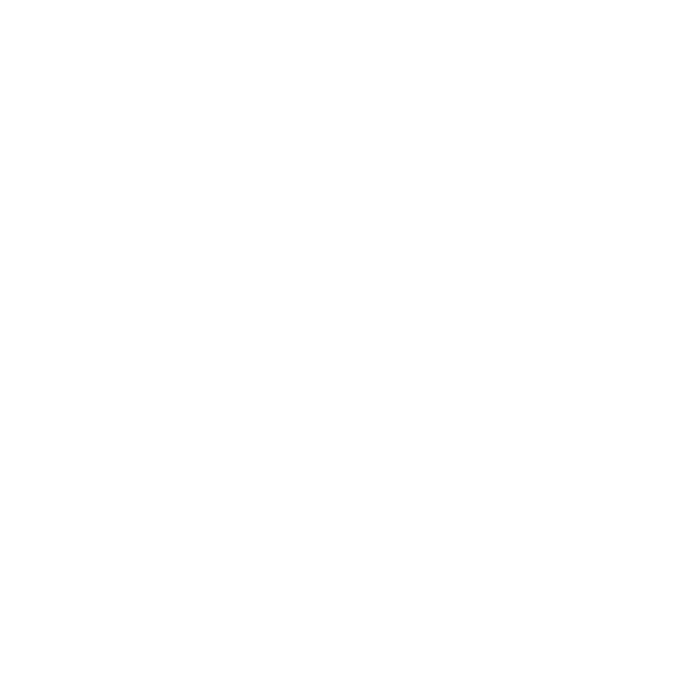

In [ ]:
from IPython.display import Image
Image(open(f'{scenario_name}.gif','rb').read())

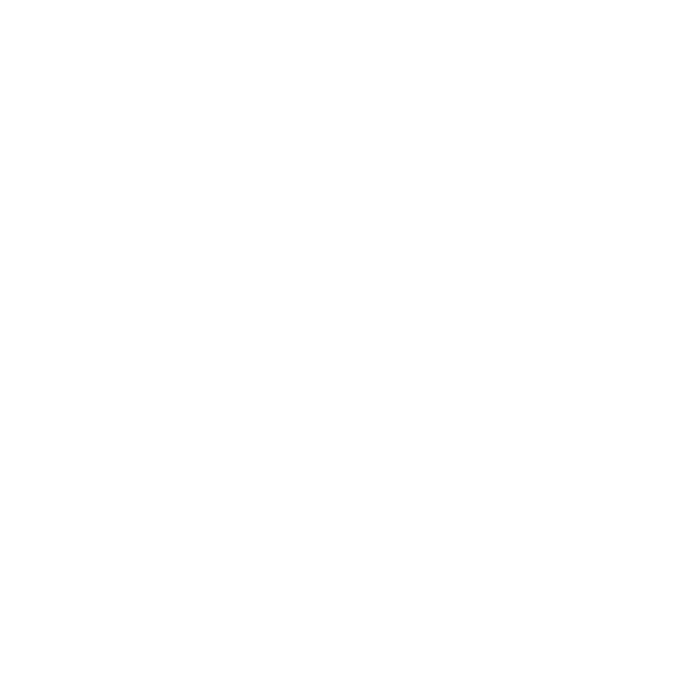

In [ ]:
import os
# Requires imagemagick to be installed to convert the gif in faster format
os.system(f"convert -delay 1x30 -loop 0 {gif_name} {scenario_name}_fast.gif")
from IPython.display import Image
Image(open(f'{scenario_name}_fast.gif','rb').read())